<a href="https://colab.research.google.com/github/Juyoung4/tensorflow_api/blob/master/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB_LSTM 모델 경량화

In [0]:
!pip install tensorflow-model-optimization

     |████████████████████████████████| 174kB 15.2MB/s 
     |████████████████████████████████| 296kB 10.5MB/s 


In [0]:
from __future__ import print_function #python2 에서 3문법 사용
import matplotlib.pyplot as plt

import tempfile
import os

import tensorflow as tf
import numpy as np

import tensorflow_model_optimization as tfmot

In [0]:
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow.keras.preprocessing.sequence as sequence
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

In [0]:
print(tf.__version__)

2.2.0


In [0]:
maxlen = 100  # cut texts after this number of words
batch_size = 32 #1 step에서 사용되는 데이터 수

## 1. IMDB 데이터셋 가져오기
IMDB는 kearas에서 제공해주는 영화 리뷰 데이터이며 긍정, 부정 감정을 분류한다.

영화 리뷰는 X_train에, 감성 정보는 y_train에 저장된다.(긍정리뷰:1, 부정리뷰:0)

num_words 인자에 20000이라고 지정하여 많이 사용하는 순 위 20000번째 까지의 단어만을 데이터셋으로 사용한다. 

In [0]:
imdb = keras.datasets.imdb


(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

17465344/17464789 [==============================] - 1s 0us/step


In [0]:
print('훈련용 리뷰 개수 : {}'.format(len(x_train)))
print('테스트용 리뷰 개수 : {}'.format(len(x_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [0]:
print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


In [0]:
print(x_train[0])

[ 1415    33     6    22    12   215    28    77    52     5    14   407
    16    82 10311     8     4   107   117  5952    15   256     4     2
     7  3766     5   723    36    71    43   530   476    26   400   317
    46     7     4 12118  1029    13   104    88     4   381    15   297
    98    32  2071    56    26   141     6   194  7486    18     4   226
    22    21   134   476    26   480     5   144    30  5535    18    51
    36    28   224    92    25   104     4   226    65    16    38  1334
    88    12    16   283     5    16  4472   113   103    32    15    16
  5345    19   178    32]


In [0]:
def print_model_sparsity(pruned_model):
  """Prints sparsity for the pruned layers in the model.
  Model Sparsity Summary
  --
  prune_lstm_1: (kernel, 0.5), (recurrent_kernel, 0.6)
  prune_dense_1: (kernel, 0.5)
  Args:
    pruned_model: keras model to summarize.
  Returns:
    None
  """
  
  def _get_sparsity(weights):
    return 1.0 - np.count_nonzero(weights) / float(weights.size)

  print("Model Sparsity Summary ({})".format(pruned_model.name))
  print("--")
  for layer in pruned_model.layers:
    if isinstance(layer, pruning_wrapper.PruneLowMagnitude):
      prunable_weights = layer.layer.get_prunable_weights()
      if prunable_weights:
        print("{}: {}".format(
            layer.name, ", ".join([
                "({}, {})".format(weight.name,
                                  str(_get_sparsity(K.get_value(weight))))
                for weight in prunable_weights
            ])))
  print("\n")

In [0]:
#모델 생성
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(20000, 128, input_length=maxlen),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Activation(activation='sigmoid')
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])
print_model_sparsity(model)

Model Sparsity Summary (sequential)
--




In [0]:

print("Train...")
model.fit(x_train, y_train, batch_size=batch_size, epochs=3,
          callbacks=[pruning_callbacks.UpdatePruningStep()],
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)

Train...
Epoch 1/3
782/782 [==============================] - 28s 36ms/step - loss: 0.4131 - accuracy: 0.8127 - val_loss: 0.3586 - val_accuracy: 0.8464
Epoch 2/3
782/782 [==============================] - 27s 35ms/step - loss: 0.2367 - accuracy: 0.9083 - val_loss: 0.3524 - val_accuracy: 0.8456
Epoch 3/3
782/782 [==============================] - 3s 4ms/step - loss: 0.5261 - accuracy: 0.8350


In [0]:
base_score,  baseline_model_accuracy = model.evaluate(x_test, y_test,
                            batch_size=batch_size)

782/782 [==============================] - 3s 4ms/step - loss: 0.5261 - accuracy: 0.8350


In [0]:
print_model_sparsity(model)
print("Baseline test score:", base_score)
print("Baseline test accuracy:",  baseline_model_accuracy)

Model Sparsity Summary (sequential)
--


Baseline test score: 0.5261352062225342
Baseline test accuracy: 0.8349999785423279


In [0]:
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

Saved baseline model to: /tmp/tmpvv87jesg.h5


## 2. baseline model with only pruning

In [0]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 3
validation_split = 0.1 # 10% of training set will be used for validation set. 


# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.30,
                                                               final_sparsity=0.70,
                                                               begin_step=1000,
                                                               end_step=3000)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_for_pruning.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_embeddin (None, 100, 128)          5120002   
_________________________________________________________________
prune_low_magnitude_lstm (Pr (None, 128)               262659    
_________________________________________________________________
prune_low_magnitude_dropout  (None, 128)               1         
_________________________________________________________________
prune_low_magnitude_dense (P (None, 1)                 259       
_________________________________________________________________
prune_low_magnitude_activati (None, 1)                 1         
Total params: 5,382,922
Trainable params: 2,691,713
Non-trainable params: 2,691,209
_________________________________________________________________


In [0]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
  

In [0]:
print("Train...")
model_for_pruning.fit(x_train, y_train, batch_size=batch_size, epochs=3,
          callbacks=[pruning_callbacks.UpdatePruningStep()],
          validation_data=(x_test, y_test))
pruned_score, pruned_acc = model_for_pruning.evaluate(x_test, y_test,
                            batch_size=batch_size)

Train...
Epoch 1/3
782/782 [==============================] - 41s 52ms/step - loss: 0.1083 - accuracy: 0.9627 - val_loss: 0.4778 - val_accuracy: 0.8266
Epoch 2/3
782/782 [==============================] - 41s 53ms/step - loss: 0.0605 - accuracy: 0.9802 - val_loss: 0.5600 - val_accuracy: 0.8264
Epoch 3/3
782/782 [==============================] - 9s 12ms/step - loss: 0.6889 - accuracy: 0.8272


In [0]:
print_model_sparsity(model_for_pruning)
print("Pruned test score:", pruned_score)
print("Pruned test accuracy:", pruned_acc)

Model Sparsity Summary (sequential)
--
prune_low_magnitude_embedding: (embedding/embeddings:0, 0.68285)
prune_low_magnitude_lstm: (lstm/lstm_cell/kernel:0, 0.6828460693359375), (lstm/lstm_cell/recurrent_kernel:0, 0.6828460693359375)
prune_low_magnitude_dense: (dense/kernel:0, 0.6796875)


Pruned test score: 0.6888934373855591
Pruned test accuracy: 0.8271600008010864


In [0]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmp7o5wfm_h.h5


## 3-1. baseline model with only quantizing

In [0]:
!pip install -q tensorflow-model-optimization

In [0]:
import tensorflow_model_optimization as tfmot

quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_apply = tfmot.quantization.keras.quantize_apply



q_annotate_model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(20000, 128, input_length=maxlen),
  tf.keras.layers.LSTM(128),
  quantize_annotate_layer(tf.keras.layers.Dropout(0.5)),
  quantize_annotate_layer(tf.keras.layers.Dense(1)),
  tf.keras.layers.Activation(activation='sigmoid')
])



In [0]:
q_aware_model = quantize_apply(q_annotate_model)

In [0]:
q_aware_model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
quant_dropout_6 (QuantizeWra (None, 128)               1         
_________________________________________________________________
quant_dense_6 (QuantizeWrapp (None, 1)                 134       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 2,691,719
Trainable params: 2,691,713
Non-trainable params: 6
_________________________________________________________________


In [0]:
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [0]:
print("Train...")
q_aware_model.fit(x_train, y_train,
                  batch_size=batch_size, epochs=3, validation_split=0.1)

Train...
Epoch 1/3
704/704 [==============================] - 23s 33ms/step - loss: 0.4271 - accuracy: 0.7982 - val_loss: 0.3595 - val_accuracy: 0.8424
Epoch 2/3
704/704 [==============================] - 23s 32ms/step - loss: 0.2343 - accuracy: 0.9078 - val_loss: 0.3698 - val_accuracy: 0.8452
Epoch 3/3
704/704 [==============================] - 22s 32ms/step - loss: 0.1417 - accuracy: 0.9495 - val_loss: 0.4304 - val_accuracy: 0.8464


In [0]:
q_aware_model_score, q_aware_model_accuracy = q_aware_model.evaluate(x_test, y_test,
                            batch_size=batch_size)

782/782 [==============================] - 4s 5ms/step - loss: 0.4463 - accuracy: 0.8362


In [0]:
print_model_sparsity(q_aware_model)
print("Quant test score:", q_aware_model_score)
print("Qaunt test accuracy:",q_aware_model_accuracy)

Model Sparsity Summary (sequential_5)
--


Quant test score: 0.4463203549385071
Qaunt test accuracy: 0.8361999988555908


In [0]:
_, quantized_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(q_aware_model, quantized_keras_file, include_optimizer=False)
print('Saved quantized Keras model to:', quantized_keras_file)

Saved quantized Keras model to: /tmp/tmpmqa6zj73.h5


In [0]:
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(quantized_keras_file)))

Size of gzipped pruned Keras model: 9967802.00 bytes


## 3-2. baseline model with post-quatizing

In [0]:
!pip install tf-nightly

### TensorFlow Lite 모델로 변환

 훈련 된 모델을 TensorFlow Lite 모델로 변환 할 수 있습니다.

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_quantizer = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
post_quan_tflite_model = converter.convert()

_,post_quan_tflite_file = tempfile.mkstemp('.tflite')

In [0]:
print('Saved post-quantized TFLite model to:',post_quan_tflite_file)

Saved post-quantized TFLite model to: /tmp/tmpj97h_l1f.tflite


In [0]:
print(post_quan_tflite_file)

/tmp/tmpj97h_l1f.tflite


In [0]:
print(y_test)
print(type(x_test[0]))

[0 1 1 ... 0 0 0]
<class 'numpy.ndarray'>


In [0]:
# tflite 정확도 측정 함수
import numpy as np

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  prediction_digits = []
  for text in x_test:

    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.

    text = np.expand_dims(text, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, text)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)


  accuracy = (prediction_digits == y_test).mean()
  return accuracy

### TFLite 모델 실행

 TensorFlow Lite interpreter를 사용하여 TensorFlow Lite 모델을 실행하십시오.

In [0]:
interpreter_post_q = tf.lite.Interpreter(model_content=post_quan_tflite_model)
interpreter_post_q.allocate_tensors()

#test_post_q_accuracy = evaluate_model(interpreter_post_q)

In [0]:
test_post_q_accuracy = evaluate_model(interpreter_post_q)



pd [0 0 0 ... 0 0 0]
yy [0 1 1 ... 0 0 0]
25000
25000


In [0]:
print('Post-Quant test accuracy:', test_post_q_accuracy)

Post-Quant test accuracy: 0.5


## 4. pruned model and quantized model convert to TFLite

### pruned model convert to tflite_model

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

Saved pruned TFLite model to: /tmp/tmpd0vvjxc4.tflite


### quantized model convert to tflite_model

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
quantized_tflite_model = converter.convert()

_, quantized_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_tflite_file, 'wb') as f:
    f.write(quantized_tflite_model)

print('Saved quantized TFLite model to:', quantized_tflite_file)

Saved quantized TFLite model to: /tmp/tmpzd47hwkm.tflite


In [0]:
interpreter_p = tf.lite.Interpreter(model_content=pruned_tflite_model)
interpreter_q = tf.lite.Interpreter(model_content=quantized_tflite_model)

interpreter_p.allocate_tensors()
interpreter_q.allocate_tensors()



In [0]:
test_accuracy_p = evaluate_model(interpreter_p)
test_accuracy_q = evaluate_model(interpreter_q)

In [0]:
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")

Prun TFLite test_accuracy: 0.5 

Quant TFLite test_accuracy: 0.5 



# 5-1. baseline model with pruning and quantizing

In [0]:
q_aware_prun_model = quantize_model(model_for_export)

In [0]:
q_aware_prun_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
q_aware_prun_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_annotate_20 (Quanti (None, 100, 128)          2560000   
_________________________________________________________________
quantize_annotate_21 (Quanti (None, 128)               131584    
_________________________________________________________________
quantize_annotate_22 (Quanti (None, 128)               0         
_________________________________________________________________
quantize_annotate_23 (Quanti (None, 1)                 129       
_________________________________________________________________
quantize_annotate_24 (Quanti (None, 1)                 0         
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [0]:
print("Train...")


q_aware_prun_model.fit(x_train, y_train,
                  batch_size=batch_size, epochs=3, validation_split=0.1)

Train...
Epoch 1/3
704/704 [==============================] - 22s 31ms/step - loss: nan - accuracy: 0.4986 - val_loss: nan - val_accuracy: 0.5124
Epoch 2/3
704/704 [==============================] - 21s 31ms/step - loss: nan - accuracy: 0.4986 - val_loss: nan - val_accuracy: 0.5124
Epoch 3/3
704/704 [==============================] - 22s 31ms/step - loss: nan - accuracy: 0.4986 - val_loss: nan - val_accuracy: 0.5124


In [0]:
# train_images_subset = train_images[0:1000] # out of 60000
# train_labels_subset = train_labels[0:1000]

# q_aware_prun_model.fit(train_images_subset, train_labels_subset,
#                   batch_size=128, epochs=4, validation_split=0.1)

In [0]:
_, q_aware_prun_model_accuracy =q_aware_prun_model.evaluate(x_test, y_test, verbose=0)

In [0]:
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")

Pruned and quantized test_accuracy: 0.5 



In [0]:
_, pruned_and_quantized_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(q_aware_prun_model, pruned_and_quantized_keras_file, include_optimizer=False)
print('Saved pruned and quantized Keras model to:', pruned_and_quantized_keras_file)

Saved pruned and quantized Keras model to: /tmp/tmph6mdda6b.h5


# 5-2. baseline model with pruning and post-quantizing

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
post_quantized_and_pruned_tflite_model = converter.convert()

_, post_quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(post_quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(post_quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', post_quantized_and_pruned_tflite_file)

Saved quantized and pruned TFLite model to: /tmp/tmpwih04u28.tflite


In [0]:
interpreter_p_post_q = tf.lite.Interpreter(model_content=post_quantized_and_pruned_tflite_model)
interpreter_p_post_q.allocate_tensors()



In [0]:
test_accuracy_p_post_q = evaluate_model(interpreter_p_post_q)

In [0]:
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")

Pruned and post-quantized test_accuracy: 0.5 



# 6. pruned and quantized model convert to TFLite

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_prun_model)
pruned_quantized_tflite_model = converter.convert()

_, pruned_quantized_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_quantized_tflite_file, 'wb') as f:
    f.write(pruned_quantized_tflite_model)

print('Saved pruned TFLite model to:', pruned_quantized_tflite_file)

Saved pruned TFLite model to: /tmp/tmp_y8meadp.tflite


In [0]:
interpreter_p_q = tf.lite.Interpreter(model_content=pruned_quantized_tflite_model)
interpreter_p_q.allocate_tensors()



In [0]:
test_accuracy_p_q = evaluate_model(interpreter_p_q)

In [0]:
print('Pruned and quantized TFLite test_accuracy:', test_accuracy_p_q,"\n")

Pruned and quantized TFLite test_accuracy: 0.5 



# 결론(Result)

## 모든 모델의 정확도

In [0]:
print('Baseline test accuracy:', baseline_model_accuracy,"\n")
print('Pruned test accuracy:', model_for_pruning_accuracy,"\n")
print('Quant test accuracy:', q_aware_model_accuracy,"\n")
print('Post-Quant test accuracy:', test_post_q_accuracy,"\n")
print('Prun TFLite test_accuracy:', test_accuracy_p,"\n")
print('Quant TFLite test_accuracy:', test_accuracy_q,"\n")
print('Pruned and quantized test_accuracy:', q_aware_prun_model_accuracy,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_post_q,"\n")
print('Pruned and post-quantized test_accuracy:', test_accuracy_p_q,"\n")

NameError: ignored

In [0]:
from matplotlib import pyplot as plt

y = [baseline_model_accuracy, model_for_pruning_accuracy,
     q_aware_model_accuracy, test_post_q_accuracy,
     test_accuracy_p, test_accuracy_q,
     q_aware_prun_model_accuracy, test_accuracy_p_post_q, test_accuracy_p_q]

x = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="skyblue", height=0.6)
plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Accuracy compare")
plt.show()

In [0]:
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="blue")
plt.xlim(0.83,0.868)

plt.yticks(x,fontsize=13)
plt.title("Accuracy compare")
plt.show()

## 모든 모델의 크기

In [0]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [0]:
print("Size of gzipped baseline Keras model: %.2f bytes\n" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes\n" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped quantizied Keras model: %.2f bytes\n" % (get_gzipped_model_size(quantized_keras_file)))
print("Size of gzipped post-quantized model: %.2f bytes\n" % (get_gzipped_model_size(post_quan_tflite_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes\n" % (get_gzipped_model_size(pruned_tflite_file)))
print("Size of gzipped quantized TFlite model: %.2f bytes\n" % (get_gzipped_model_size(quantized_tflite_file)))
print("Size of gzipped pruned and quantized Keras model: %.2f bytes\n" % (get_gzipped_model_size(pruned_and_quantized_keras_file)))
print("Size of gzipped pruned and post-quantized model: %.2f bytes\n" % (get_gzipped_model_size(post_quantized_and_pruned_tflite_file)))
print("Size of gzipped pruned and quantized TFlite model: %.2f bytes\n" % (get_gzipped_model_size(pruned_quantized_tflite_file)))

Size of gzipped baseline Keras model: 9966407.00 bytes

Size of gzipped pruned Keras model: 4301966.00 bytes

Size of gzipped quantizied Keras model: 10061041.00 bytes

Size of gzipped post-quantized model: 144.00 bytes

Size of gzipped pruned TFlite model: 10063918.00 bytes

Size of gzipped quantized TFlite model: 10063936.00 bytes

Size of gzipped pruned and quantized Keras model: 24956.00 bytes

Size of gzipped pruned and post-quantized model: 6338.00 bytes

Size of gzipped pruned and quantized TFlite model: 25982.00 bytes



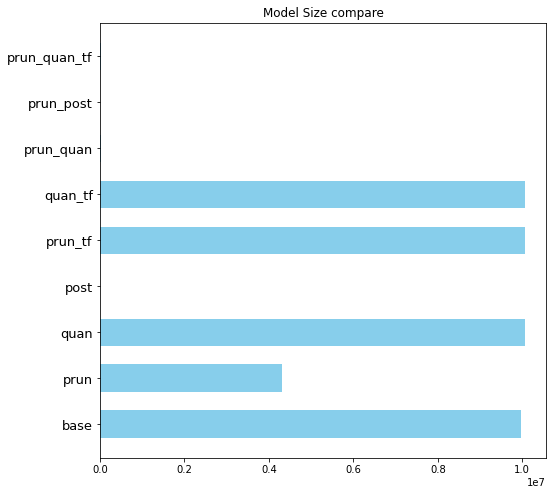

In [0]:
y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]


x = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]
plt.figure(figsize=(8, 8))
plt.barh(x, y, color="skyblue", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

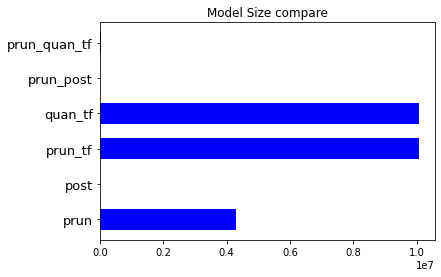

In [0]:
y = [get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]

x = ["prun", "post",
     "prun_tf","quan_tf",
     "prun_post", "prun_quan_tf"]

plt.barh(x, y, color="blue", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()


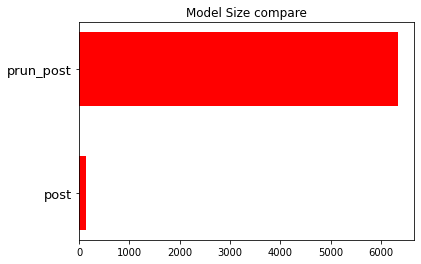

In [0]:
y = [get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file)]

x = ["post",
     "prun_post"]

plt.barh(x, y, color="red", height=0.6)
#plt.xlim(0.0,0.9)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()

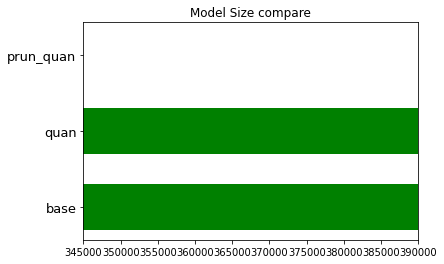

In [0]:
y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file)]


x = ["base", "quan", "prun_quan"]

plt.barh(x, y, color="green", height=0.6)
plt.xlim(345000, 390000)

plt.yticks(x,fontsize=13)
plt.title("Model Size compare")
plt.show()


## accuracy and model size

In [0]:
x = [baseline_model_accuracy, model_for_pruning_accuracy,
     q_aware_model_accuracy, test_post_q_accuracy,
     test_accuracy_p, test_accuracy_q,
     q_aware_prun_model_accuracy, test_accuracy_p_post_q, test_accuracy_p_q]

y = [get_gzipped_model_size(keras_file),
     get_gzipped_model_size(pruned_keras_file),
     get_gzipped_model_size(quantized_keras_file),
     get_gzipped_model_size(post_quan_tflite_file),
     get_gzipped_model_size(pruned_tflite_file),
     get_gzipped_model_size(quantized_tflite_file),
     get_gzipped_model_size(pruned_and_quantized_keras_file),
     get_gzipped_model_size(post_quantized_and_pruned_tflite_file),
     get_gzipped_model_size(pruned_quantized_tflite_file)]

z = ["base", "prun", "quan", "post",
     "prun_tf","quan_tf", "prun_quan",
     "prun_post", "prun_quan_tf"]

c = ['b','g','r','c','yellow','m','k','orange',"brown"]
d = [(10,10),(10,10),(10,-15),(10,10),(10,-15),(10,10),(10,10),(10,10),(10,10)]
plt.figure(figsize=(8, 8))
plt.scatter(x,y, color=c)

for xs,ys in zip(x,y):
    plt.annotate(z[x.index(xs)], (xs,ys), textcoords="offset points",xytext=d[x.index(xs)],ha='right')
    
plt.ylabel('Model Size')
plt.xlabel('Accuracy')
plt.show()

NameError: ignored